In [1]:
import os
os.chdir('..')
os.chdir('..')
import torch
from SA_model import SlotAttentionVideoAutoEncoder,Initializer
from data_loader import Dataset_AffectNet_image
import torchvision
import matplotlib.pyplot as plt
from utils import data_augm,data_adapt
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

affectNet_img = '/home/ens/AT91140/project_DA/Datasets/AffectNet/Manually_Annotated_Images'
affectNet_annot_train = '/home/ens/AT91140/project_DA/Datasets/AffectNet/training_wo_landmark.csv'
affectNet_annot_val = '/home/ens/AT91140/project_DA/Datasets/AffectNet/validation_wo_landmark.csv'


save_path =  '/home/ens/AT91140/project_DA/models/'

In [2]:
device_ids = [3]
for d in device_ids:
    torch.cuda.set_device(d)
    torch.cuda.empty_cache()
    #torch.cuda.current_device()
    torch.cuda.get_device_name()
device = f'cuda:{device_ids[0]}'

In [3]:
class Classifier(torch.nn.Module):
    def __init__(self,nb_slot,dim_slot,nb_class):
        super(Classifier,self).__init__()
        self.fc1 = torch.nn.Linear(nb_slot*dim_slot,100)
        self.fc2 = torch.nn.Linear(100,nb_class)


    def forward(self,x):
        x = x.reshape(x.shape[0],-1)
        x = self.fc1(x).relu()
        x = self.fc2(x).softmax(dim=-1)
        return x
    
class Residual_classifier(torch.nn.Module):
    def __init__(self,nb_slot,dim_slot,nb_class,nb_residual_blocks=4,hidden_state=1000,dropout_rate=0):
        super(Residual_classifier,self).__init__()
        self.fc_input = torch.nn.Linear(nb_slot*dim_slot,hidden_state)

        self.residual_blocks = torch.nn.ModuleList()
        for l in range(nb_residual_blocks):
            layer = []
            layer.append(torch.nn.Linear(hidden_state,hidden_state))
            layer.append(torch.nn.ReLU())
            layer.append(torch.nn.Dropout(dropout_rate))

            self.residual_blocks.append(torch.nn.Sequential(*layer))

        self.fc_output = torch.nn.Linear(hidden_state,nb_class)


    def forward(self,x):
        x = x.reshape(x.shape[0],-1)
        x = self.fc_input(x).relu()
        for block in self.residual_blocks:
            x = x+block(x)
        x = self.fc_output(x).softmax(dim=-1)
        return x

class SlotLinear(torch.nn.Module):
    def __init__(self,nb_slot,dim_slot,nb_output=100):
        super(SlotLinear,self).__init__()
        self.a = torch.nn.Parameter(torch.randn(nb_slot,nb_output,dim_slot))
        self.b = torch.nn.Parameter(torch.randn(nb_slot,nb_output))
    def forward(self,x):
        y = torch.einsum('bnd,nkd->bnk',x,self.a)+self.b
        return y

class Macro_Micro_classifier(torch.nn.Module):
    def __init__(self,nb_slot,dim_slot,nb_class,hidden_state=50,dropout_rate=0):
        super(Macro_Micro_classifier,self).__init__()
        self.fc_global = torch.nn.Linear(1000,dim_slot)
        self.fc_slot = SlotLinear(nb_slot+1,dim_slot,hidden_state)
        self.fc_output1 = torch.nn.Linear(hidden_state*(nb_slot+1),100)
        self.fc_output2 = torch.nn.Linear(100,nb_class)
    def forward(self,slots,R):
        R = self.fc_global(R).relu().unsqueeze(1)
        x = torch.concat([slots,R],dim=1)
        x = self.fc_slot(x).relu()
        x = self.fc_output1(x.reshape(x.shape[0],-1)).relu()
        x = self.fc_output2(x).softmax(dim=-1)
        return x





In [4]:
EPOCH = 300
BATCH_SIZE = 100
EARLY_STOPPING = 30
LEARNING_RATE = 0.0001
RESOLUTION = 224
nb_class = 7
NB_SLOT = 5
DIM_SLOT = 100
ITER = 2

#load_model_name = 'AffectNet_layer_Mm_5_100_no_decoder.pt'
#load_model_name_init = 'init_AffectNet_layer_Mm_5_100_no_decoder.pt'
#load_model_name_task = 'task_AffectNet_layer_Mm_5_100_no_decoder.pt'

save_model_name = 'AffectNet_224_layer_Mm_5_100_no_decoder.pt'
save_model_name_init = 'init_AffectNet_224_layer_Mm_5_100_no_decoder.pt'
save_model_name_task = 'task_AffectNet_224_layer_Mm_5_100_no_decoder.pt'

tr = data_augm(RESOLUTION)
tr_test = data_adapt(RESOLUTION)
tr_size = torchvision.transforms.Resize((RESOLUTION,RESOLUTION),antialias=True)

In [5]:
dataset_train = Dataset_AffectNet_image(affectNet_img, affectNet_annot_train,
                                    tr.transform,crop=True,nb_image=None,
                                    type_output='expression',balanced=True,nb_class=nb_class,preload=False)




dataset_test = Dataset_AffectNet_image(affectNet_img, affectNet_annot_val,tr_test.transform,crop=True,type_output='expression',balanced=False,nb_class=nb_class,preload=False)





In [6]:
loader_train = torch.utils.data.DataLoader(dataset_train,
                                             batch_size=BATCH_SIZE, shuffle=True,
                                             num_workers=4,drop_last = True)

loader_test = torch.utils.data.DataLoader(dataset_test,
                                             batch_size=BATCH_SIZE, shuffle=False,
                                             num_workers=4)

In [7]:
class Classifier_Transformer(torch.nn.Module):
    def __init__(self,NB_SLOT,DIM_SLOT,nb_class):
        super(Classifier_Transformer,self).__init__()
        self.transformer_encoder = torch.nn.TransformerEncoderLayer(DIM_SLOT,8)
        self.fc1 = torch.nn.Linear(NB_SLOT*DIM_SLOT,100)
        self.fc2 = torch.nn.Linear(100,nb_class)
    def forward(self,x):
        tok = self.transformer_encoder(x)
        rep = tok.reshape(tok.shape[0],-1)
        rep = self.fc1(rep).relu()
        rep = self.fc2(rep).softmax(dim=-1)

        return rep
    
class Classifier_vocab(torch.nn.Module):
    def __init__(self,NB_SLOT,DIM_SLOT,nb_class,nb_voc=100):
        super(Classifier_vocab,self).__init__()
        self.voc = torch.nn.Parameter(torch.randn(nb_voc,DIM_SLOT))
        self.fc1 = torch.nn.Linear(NB_SLOT*DIM_SLOT,100)
        self.fc2 = torch.nn.Linear(100,nb_class)
        self.reduc = DIM_SLOT**-0.5
    def forward(self,slots):
        attn = (torch.einsum('bnd,vd->bnv',slots,self.voc)*self.reduc).softmax(dim=-1)
        concept_slots = torch.einsum('bnv,vd->bnd',attn,self.voc)
        print(attn[0].max(dim=-1)[1])
        y = self.fc1(concept_slots.reshape(concept_slots.shape[0],-1)).relu()
        y = self.fc2(y).softmax(dim=-1)

        return y

class Classifier_vocab_2(torch.nn.Module):
    def __init__(self,NB_SLOT,DIM_SLOT,nb_class,nb_voc=100,dim_voc = 50):
        super(Classifier_vocab_2,self).__init__()
        if dim_voc is None:
            dim_voc = DIM_SLOT
        
        self.voc_k = torch.nn.Parameter(torch.randn(nb_voc,dim_voc))
        self.voc_v = torch.nn.Parameter(torch.randn(nb_voc,dim_voc))
        self.to_q = torch.nn.Linear(DIM_SLOT,dim_voc)
        self.fc1 = torch.nn.Linear(NB_SLOT*dim_voc,100)
        self.fc2 = torch.nn.Linear(100,nb_class)
        self.reduc = dim_voc**-0.5
    def forward(self,slots):
        q = self.to_q(slots)
        attn = (torch.einsum('bnd,vd->bnv',q,self.voc_k)*self.reduc).softmax(dim=-1)
        concept_slots = torch.einsum('bnv,vd->bnd',attn,self.voc_v)

        y = self.fc1(concept_slots.reshape(concept_slots.shape[0],-1)).relu()
        y = self.fc2(y).softmax(dim=-1)

        return y

In [8]:
loss_t = torch.nn.CrossEntropyLoss(reduction='sum')
loss_fn = torch.nn.MSELoss(reduction='sum')

In [9]:
model = SlotAttentionVideoAutoEncoder((RESOLUTION,RESOLUTION),ITER,DIM_SLOT,depth=[True,True,True],final_R=True)
#model = torch.nn.DataParallel(model,device_ids)
#model.load_state_dict(torch.load(save_path+load_model_name))
#model.load_state_dict(torch.load(save_path+save_model_name))
model.to(device)

#model_task = Classifier_vocab_2(NB_SLOT,DIM_SLOT,nb_class)
#model_task = Residual_classifier(NB_SLOT,DIM_SLOT,nb_class,nb_residual_blocks=0,hidden_state=100)
model_task = Macro_Micro_classifier(NB_SLOT,DIM_SLOT,nb_class,hidden_state=100)
#model_task = Classifier(NB_SLOT,DIM_SLOT,nb_class)
#model_task = torch.nn.DataParallel(model_task,device_ids).to(device)
#model_task.load_state_dict(torch.load(save_path+save_model_name_task))
model_task.to(device)

model_init = Initializer(NB_SLOT,DIM_SLOT)
#model_init = torch.nn.DataParallel(model_init,device_ids)
#model_init.load_state_dict(torch.load(save_path+load_model_name_init))
#model_init.load_state_dict(torch.load(save_path+save_model_name_init))
model_init.to(device)

Initializer()

In [10]:
optimizer = torch.optim.Adam(list(model.parameters())+list(model_task.parameters())+list(model_init.parameters()),lr=LEARNING_RATE)

In [11]:
min_loss_val = None
dic_log = {'loss_CE_train':[],'loss_CE_val':[],'loss_acc_train':[],'loss_acc_val':[],"loss_MSE_val":[]}
count = 0 

In [12]:
# 100 : 267
# 100 vocab : 128
# 200: 57
for i in model.encoder.first_conc.parameters():
    i.requires_grad = False
for i in model.encoder.layer_blocks.parameters():
    i.requires_grad = False
for i in model.encoder.final_layers.parameters():
    i.requires_grad = False
for epoch in range(EPOCH):
    dataset_train.reset()
    if epoch == 10:
        for i in model.encoder.first_conc.parameters():
            i.requires_grad = True
        for i in model.encoder.layer_blocks.parameters():
            i.requires_grad = True
        for i in model.encoder.final_layers.parameters():
            i.requires_grad = True
    loss_task_tot = 0
    loss_rec_tot = 0
    loss_tot = 0
    elem_sum = 0
    true_response = 0
    model.train()
    model_task.train()
    model_init.train()
    
    loop_train = tqdm(loader_train,colour='BLUE')
    for i,pack in enumerate(loop_train):

        img_tensor = pack[0].to(device)
        target_tensor = pack[1].to(device)
        slots_init,_,_ = model_init(int(img_tensor.shape[0]))

        recons, masks, slots,R = model(img_tensor,slots_init)

        # TASK REC
        soft_masks = masks.softmax(dim=1)
        recon_combined = torch.sum(soft_masks*recons,dim=1)
        loss_rec = loss_fn(recon_combined,img_tensor)

        # TASK CLASS
        output = model_task(slots,R)
        loss_task = loss_t(output,target_tensor) 
        

        loss = loss_task + loss_rec/RESOLUTION/RESOLUTION

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        true_response += float(torch.sum(output.max(dim=-1)[1] == target_tensor))
        elem_sum += img_tensor.shape[0]
        loss_task_tot += float(loss_task)
        loss_rec_tot += float(loss_rec)
        loss_tot += float(loss)
        loop_train.set_description(f"Epoch [{epoch}/{EPOCH}] training")
        loop_train.set_postfix(loss_task = loss_task_tot/elem_sum,accuracy=true_response/elem_sum*100,loss_rec=loss_rec_tot/elem_sum/RESOLUTION/RESOLUTION,loss=loss_tot/elem_sum)
    
    model.eval()
    model_init.eval()
    model_task.eval()
    loss_task_val = 0
    loss_rec_val = 0
    elem_sum_val = 0
    true_response_val  =0
    loop_test = tqdm(loader_test,colour='GREEN')
    for pack in loop_test:
        img_tensor = pack[0].to(device)
        target_tensor = pack[1].to(device)

        with torch.no_grad():
            slots_init,_,_ = model_init(int(img_tensor.shape[0]))
            recons, masks, slots, R = model(img_tensor,slots_init)
            output  = model_task(slots,R)

        # TASK REC
        soft_masks = masks.softmax(dim=1)
        recon_combined = torch.sum(soft_masks*recons,dim=1)
        loss_rec = loss_fn(recon_combined,img_tensor)

        # TASK CLASS
        loss_task = loss_t(output,target_tensor)
        result = output.max(dim=-1)[1]

        true_response_val += float(torch.sum(result == target_tensor))
        elem_sum_val += img_tensor.shape[0]
        loss_task_val += float(loss_task)
        loss_rec_val += float(loss_rec)

        loop_test.set_description(f"Test count {count}")
        loop_test.set_postfix(loss_task = loss_task_val/elem_sum_val,accuracy=true_response_val/elem_sum_val*100,loss_rec=loss_rec_val/elem_sum_val/RESOLUTION/RESOLUTION)
    
    dic_log['loss_CE_train'].append(loss_task_tot/elem_sum)
    dic_log['loss_acc_train'].append(true_response/elem_sum*100)
    dic_log['loss_CE_val'].append(loss_task_val/elem_sum_val)
    dic_log['loss_acc_val'].append(true_response_val/elem_sum_val*100)
    dic_log['loss_MSE_val'].append(loss_rec_val/elem_sum_val/RESOLUTION/RESOLUTION)
    
    if epoch <100 or min_loss_val is None or min_loss_val > loss_task_val/elem_sum_val:
        count = 0
        torch.save(model.state_dict(),save_path+save_model_name)
        torch.save(model_task.state_dict(),save_path+save_model_name_task)
        torch.save(model_init.state_dict(),save_path+save_model_name_init)
        min_loss_val = loss_task_val/elem_sum_val
    else:
        count +=1
        if count >= EARLY_STOPPING:
            break
    




Test count 29: 100%|██████████| 35/35 [00:09<00:00,  3.68it/s, accuracy=61.4, loss_rec=0.17, loss_task=1.55] 


In [23]:
import pandas as pd
dataframe = pd.DataFrame(dic_log)
#dataframe.to_csv(save_path+'result_100_5_8_class.csv')

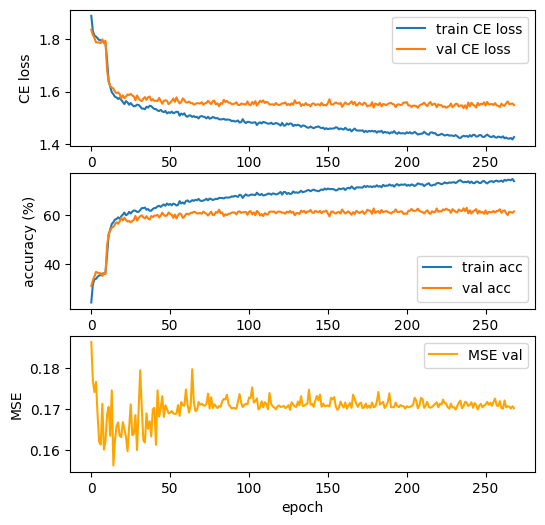

In [24]:
fig, axs = plt.subplots(3,1,figsize = (6,6))
axs = axs.flat
axs[0].plot(dic_log['loss_CE_train'],label='train CE loss')
axs[0].plot(dic_log['loss_CE_val'],label='val CE loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('CE loss')
axs[0].legend()
axs[1].plot(dic_log['loss_acc_train'],label='train acc')
axs[1].plot(dic_log['loss_acc_val'],label='val acc')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('accuracy (%)')
axs[1].legend()
axs[2].plot(dic_log['loss_MSE_val'],label='MSE val',color='ORANGE')
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('MSE')
axs[2].legend()


In [15]:
model = SlotAttentionVideoAutoEncoder((RESOLUTION,RESOLUTION),ITER,DIM_SLOT,depth=[True,True,True],final_R=True)
#model = torch.nn.DataParallel(model,device_ids)
model.load_state_dict(torch.load(save_path+'AffectNet_224_layer_Mm_5_100_no_decoder.pt'))
model.to(device)

#model_task = Classifier_vocab_2(NB_SLOT,DIM_SLOT,nb_class)
#model_task = Classifier(NB_SLOT,DIM_SLOT,nb_class)
#model_task = Residual_classifier(NB_SLOT,DIM_SLOT,nb_class,nb_residual_blocks=0,hidden_state=100)
#model_task = torch.nn.DataParallel(model_task,device_ids).to(device)
model_task = Macro_Micro_classifier(NB_SLOT,DIM_SLOT,nb_class,hidden_state=100)
model_task.load_state_dict(torch.load(save_path+'task_AffectNet_224_layer_Mm_5_100_no_decoder.pt'))
model_task.to(device)

model_init = Initializer(NB_SLOT,DIM_SLOT)
#model_init = torch.nn.DataParallel(model_init,device_ids)
model_init.load_state_dict(torch.load(save_path+'init_AffectNet_224_layer_Mm_5_100_no_decoder.pt'))
model_init.to(device)

Initializer()

In [16]:
model.SlotAttention

MultiDepthSlotAttention(
  (to_q): ModuleList(
    (0-2): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
  (to_k): ModuleList(
    (0-2): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
  (to_v): ModuleList(
    (0-2): 3 x Linear(in_features=100, out_features=100, bias=True)
  )
  (norm_input): ModuleList(
    (0-2): 3 x LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  )
  (norm_slots): ModuleList(
    (0-2): 3 x LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  )
  (gru): GRUCell(100, 100)
  (fc1_slot): Linear(in_features=100, out_features=100, bias=True)
  (fc2_slot): Linear(in_features=100, out_features=100, bias=True)
  (norm_pre_ff): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu): ReLU()
)

In [17]:
model.eval()
model_init.eval()
model_task.eval()
M  = torch.zeros(nb_class,nb_class)
loss_task_val = 0
loss_rec_val = 0
elem_sum_val = 0
true_response_val  =0
loop_test = tqdm(loader_test,colour='GREEN')
for pack in loop_test:
        img_tensor = pack[0].to(device)
        target_tensor = pack[1].to(device)

        with torch.no_grad():
                slots_init,_,_ = model_init(int(img_tensor.shape[0]))
                recons, masks, slots,R = model(img_tensor,slots_init)
                output  = model_task(slots,R)

        # TASK REC
        soft_masks = masks.softmax(dim=1)
        recon_combined = torch.sum(soft_masks*recons,dim=1)
        loss_rec = loss_fn(recon_combined,img_tensor)

        # TASK CLASS
        loss_task = loss_t(output,target_tensor)
        result = output.max(dim=-1)[1]

        for b in range(result.shape[0]):
                M[int(target_tensor[b])][int(result[b])] += 1
        true_response_val += float(torch.sum(result == target_tensor))
        elem_sum_val += img_tensor.shape[0]
        loss_task_val += float(loss_task)
        loss_rec_val += float(loss_rec)

        loop_test.set_description(f"Test")
        loop_test.set_postfix(loss_task = loss_task_val/elem_sum_val,accuracy=true_response_val/elem_sum_val*100,loss_rec=loss_rec_val/elem_sum_val/RESOLUTION/RESOLUTION)
accuracy = true_response_val/elem_sum_val*100

Test: 100%|██████████| 35/35 [00:08<00:00,  4.00it/s, accuracy=62.8, loss_rec=0.172, loss_task=1.54]


Text(0.5, 1.0, 'Test confusion matrix')

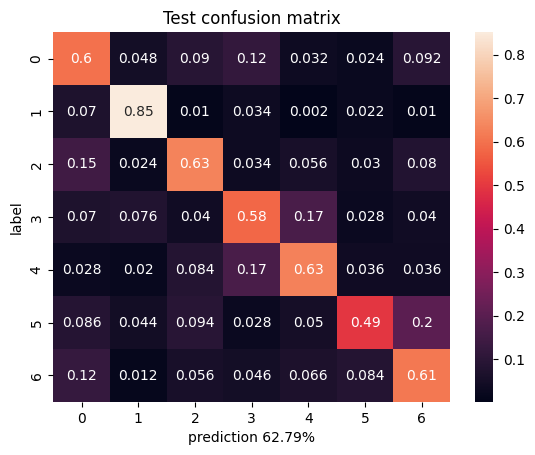

In [18]:
import seaborn as sns
sns.heatmap(M/M.sum(dim=1,keepdim=True),annot=True)
plt.xlabel(f'prediction {round(accuracy,2)}%')
plt.ylabel('label')
plt.title('Test confusion matrix')

<Axes: >

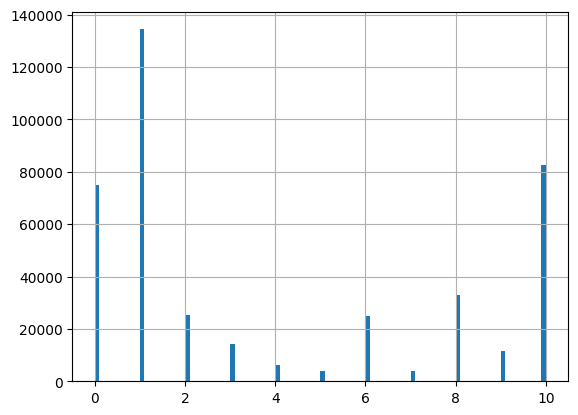

In [19]:
import pandas as pd
dataframe = pd.read_csv(affectNet_annot_train,index_col=0)
dataframe['expression'].hist(bins=100)

In [20]:
img_id = 90
#dataset_train.reset()
input = dataset_test[img_id][0]
target = dataset_test[img_id][1]

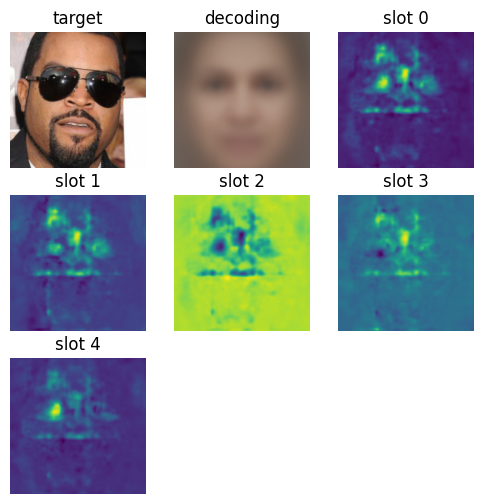

In [21]:
import math
init_slots,_,_ = model_init(1)

recons,masks,slots,R = model(input.unsqueeze(0).to(device),init_slots)
result  = model_task(slots,R)
recon_combined = torch.sum(masks.softmax(dim=1)*recons,dim=1)
#mse =  model_task(slots)
nb_slot = recons.shape[1]
fig, axs = plt.subplots(int(math.sqrt(nb_slot+2)+1),int(math.sqrt(nb_slot+2)+1),figsize = (6,6))
axs = axs.flat
axs[0].imshow((input).permute(1,2,0))
axs[0].set_title('target')
axs[0].axis('off')
axs[1].imshow(recon_combined[0].cpu().detach().permute(1,2,0).numpy())
axs[1].set_title('decoding')
axs[1].axis('off')
for i in range(nb_slot):
    axs[2+i].imshow(((masks.softmax(dim=1)[0,i]).permute(1,2,0)).cpu().detach().numpy())
    axs[2+i].set_title(f'slot {i}')
    axs[2+i].axis('off')
for i in range(2+nb_slot,int(math.sqrt(nb_slot+2)+1)*(int(math.sqrt(nb_slot+2)+1))):
    axs[i].axis('off')

In [22]:
par = [ a for a in model_task.fc_input.parameters()]


AttributeError: 'Macro_Micro_classifier' object has no attribute 'fc_input'

In [ ]:
par[0].reshape(100,5,100).abs().mean(dim=-1)

tensor([[0.0338, 0.0403, 0.0352, 0.0351, 0.0339],
        [0.0457, 0.0364, 0.0368, 0.0358, 0.0405],
        [0.0446, 0.0380, 0.0403, 0.0339, 0.0378],
        [0.0379, 0.0333, 0.0325, 0.0369, 0.0492],
        [0.0395, 0.0296, 0.0358, 0.0354, 0.0329],
        [0.0318, 0.0368, 0.0402, 0.0306, 0.0300],
        [0.0383, 0.0306, 0.0396, 0.0378, 0.0476],
        [0.0406, 0.0343, 0.0353, 0.0294, 0.0345],
        [0.0369, 0.0287, 0.0321, 0.0341, 0.0541],
        [0.0405, 0.0295, 0.0332, 0.0330, 0.0378],
        [0.0339, 0.0358, 0.0422, 0.0260, 0.0319],
        [0.0431, 0.0400, 0.0457, 0.0297, 0.0484],
        [0.0392, 0.0306, 0.0331, 0.0375, 0.0455],
        [0.0455, 0.0260, 0.0328, 0.0358, 0.0545],
        [0.0416, 0.0278, 0.0353, 0.0394, 0.0504],
        [0.0372, 0.0353, 0.0385, 0.0325, 0.0432],
        [0.0218, 0.0237, 0.0190, 0.0221, 0.0237],
        [0.0266, 0.0261, 0.0241, 0.0259, 0.0217],
        [0.0302, 0.0394, 0.0393, 0.0277, 0.0355],
        [0.0406, 0.0398, 0.0398, 0.0382, 0.0373],
